# library import

In [ ]:
!pip install japanize-matplotlib
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datetime as dt
from lightgbm import early_stopping
import lightgbm as lgbm
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from matplotlib import dates as mdates
import re
import optuna
from optuna.logging import set_verbosity
from sklearn.model_selection import KFold

# import warnings
# warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd {"/content/drive/MyDrive/Competitions/Nishika/yasai"}

/content/drive/MyDrive/Competitions/Nishika/yasai


# Data Load

In [ ]:
df_merge = pd.read_csv("input/merge_data_preprocessing_v9.csv", parse_dates=["date"])
df_sample = pd.read_csv("input/sample_submission.csv")

In [ ]:
df_weather = pd.read_csv("input/weather.csv", parse_dates=["date"]).drop(["min_temp_time","max_temp_time"], axis=1)
WEATHER_AREA_DICT = {
        "仙台": "宮城",
        "佐賀": "佐賀",
        "前橋": "群馬",
        "千葉": "千葉",
        "名古屋": "愛知",
        "和歌山": "和歌山",
        "宇都宮": "栃木",
        "宮崎": "宮崎",
        "山形": "山形",
        "帯広": "北海道",
        "徳島": "徳島",
        "新潟": "新潟",
        "東京": "東京",
        "松山": "愛媛",
        "横浜": "神奈川",
        "水戸": "茨城",
        "浜松": "静岡",
        "熊本": "熊本",
        "熊谷": "埼玉",
        "甲府": "山梨",
        "盛岡": "岩手",
        "神戸": "兵庫",
        "福岡": "福岡",
        "福島": "福島",
        "秋田": "秋田",
        "那覇": "沖縄",
        "長崎": "長崎",
        "長野": "長野",
        "青森": "青森",
        "高松": "香川",
        "高知": "高知",
        "鹿児島": "鹿児島"
    }
df_weather["area"] = df_weather["area"].map(WEATHER_AREA_DICT)

In [ ]:
df_weather_from_2019 = df_weather[df_weather["date"].dt.strftime("%Y-%m") >= "2015-01"].copy()

df_weather_from_2019["month-day"] = df_weather_from_2019["date"].map(lambda x: x.strftime("%m-%d"))
df_weather_from_2019["month-day_+1"] = (df_weather_from_2019["date"] + dt.timedelta(days=1)).dt.strftime("%m-%d")
df_weather_from_2019["month-day_-1"] = (df_weather_from_2019["date"] + dt.timedelta(days=-1)).dt.strftime("%m-%d")

df_weather_from_2019_plumai1 = (df_weather_from_2019.groupby(["month-day", "area"], as_index=False).mean().drop(["month-day", "area"], axis=1) + df_weather_from_2019.groupby(["month-day_+1", "area"], as_index=False).mean().drop(["month-day_+1", "area"], axis=1) + df_weather_from_2019.groupby(["month-day_-1", "area"], as_index=False).mean().drop(["month-day_-1", "area"], axis=1)) / 3
df_weather_from_2019_plumai1.columns = ["mean_temp_plumai1", "max_temp_plumai1", "min_temp_plumai1", "sum_rain_plumai1", "sun_time_plumai1", "mean_humid_plumai1"]

df_weather_monthday_avg = df_weather_from_2019.groupby(["month-day", "area"], as_index=False).mean()
df_weather_monthday_avg.columns = ["month-day", "area", "mean_temp_avg",	"max_temp_avg",	"min_temp_avg",	"sum_rain_avg",	"sun_time_avg"	,"mean_humid_avg"]

df_weather_monthday_avg = pd.concat([df_weather_monthday_avg, df_weather_from_2019_plumai1], axis=1) 

df_merge["month-day"] = df_merge["date"].map(lambda x: x.strftime("%m-%d"))
df_merge = pd.merge(df_merge, df_weather_monthday_avg, how="left", on=["month-day", "area"]).drop(["month-day"], axis=1)

In [ ]:
def moving_avg(df, kind):
    df = df.query("kind == @kind").copy()
    df["amount_moving_avg"] = df["amount"].rolling(window=5).mean()
    df["amount_diff"] = df["amount"].diff()
    
    return df

df_merge_ = pd.DataFrame()
for kind in df_merge["kind"].unique():
    df_merge_ = pd.concat([df_merge_, moving_avg(df_merge, kind)])

In [ ]:
df_train_amount = df_merge_.query("data_flag == 'train'")
df_test_amount = df_merge_.query("data_flag == 'test'")
df_train_amount[["amount_moving_avg", "amount_diff"]] = df_train_amount[["amount_moving_avg","amount_diff"]].fillna(df_train_amount[["amount_moving_avg","amount_diff"]].median())
df_merge = pd.concat([df_train_amount, df_test_amount])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
df_merge

,kind,date,amount,mode_price,data_flag,year,month,year-month,month-range,dayofweek,...,sun_time_avg,mean_humid_avg,mean_temp_plumai1,max_temp_plumai1,min_temp_plumai1,sum_rain_plumai1,sun_time_plumai1,mean_humid_plumai1,amount_moving_avg,amount_diff
0,だいこん,2015-01-05,383675.0,1404.0,train,2015,1,2015-01,1-上旬,Mon,...,6.987500,49.375000,6.625000,10.612500,2.866667,0.687500,6.216667,50.333333,99242.4,887.0
1,だいこん,2015-01-06,306110.0,972.0,train,2015,1,2015-01,1-上旬,Tue,...,3.837500,54.750000,6.429167,10.275000,2.870833,0.770833,5.779167,49.375000,99242.4,-77565.0
2,だいこん,2015-01-08,323297.0,864.0,train,2015,1,2015-01,1-上旬,Thu,...,5.662500,54.125000,6.562500,10.600000,3.029167,3.187500,6.625000,48.541667,99242.4,17187.0
3,だいこん,2015-01-09,192618.0,702.0,train,2015,1,2015-01,1-上旬,Fri,...,7.700000,47.500000,6.791667,10.533333,3.395833,3.062500,6.762500,48.541667,99242.4,-130679.0
4,だいこん,2015-01-10,249458.0,810.0,train,2015,1,2015-01,1-上旬,Sat,...,6.925000,44.000000,7.020833,10.737500,3.437500,1.145833,6.691667,47.000000,291031.6,56840.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132327,ほうれんそう,2022-05-26,NaN,NaN,test,2022,5,2022-05,5-下旬,Thu,...,6.700000,63.285714,22.157143,26.919048,18.514286,1.309524,7.076190,64.952381,NaN,NaN
132328,ほうれんそう,2022-05-27,NaN,NaN,test,2022,5,2022-05,5-下旬,Fri,...,7.014286,65.142857,21.895238,26.109524,18.095238,1.857143,6.176190,64.857143,NaN,NaN
132329,ほうれんそう,2022-05-28,NaN,NaN,test,2022,5,2022-05,5-下旬,Sat,...,4.814286,66.142857,22.009524,26.280952,18.052381,2.547619,6.871429,65.285714,NaN,NaN
132330,ほうれんそう,2022-05-30,NaN,NaN,test,2022,5,2022-05,5-下旬,Mon,...,7.757143,65.857143,22.561905,27.180952,18.700000,1.666667,7.633333,66.761905,NaN,NaN


# Preprocessing

## Label encoding

In [ ]:
def label_encoding(df, column_list):
    for column in column_list:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    return df

In [ ]:
LABEL_LIST = ["year", "month", "year-month", "month-range", "dayofweek", "area", "emagency"]
df_merge = label_encoding(df_merge, LABEL_LIST)

## Train Test Divide

In [ ]:
df_train = df_merge.query("data_flag == 'train'")
df_test = df_merge.query("data_flag == 'test'")

## Drop unused columns

In [ ]:
def drop_columns(train, test, columns):
    train = train.drop(labels=columns, axis=1)
    test = test.drop(labels=columns, axis=1)
    return train, test

In [ ]:
DROP_LIST = ["data_flag"]
df_train, df_test = drop_columns(df_train, df_test, DROP_LIST)

# modeiling

## Metric

In [ ]:
def _cal_rule_metric(y_true, y_pred):
    return 100 * np.sqrt(np.mean(((y_pred - y_true) / y_true)**2))

## LightGBM class

In [ ]:
class Objective:
    def __init__(self, X_train, y_train, X_valid, y_valid):
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        
    def __call__(self, trial):
        params = {
            "objective": "regression",
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 32),
            "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.1, 1.0),
            "subsample": trial.suggest_loguniform("subsample", 0.6, 0.95),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0,),
            "learning_rate": 0.1,
            "n_estimators": 10000,
            "importance_type": "gain",
            "random_state": 1234
        }
        
        reg = lgbm.LGBMModel(**params)
        reg.fit(
            self.X_train,
            self.y_train,
            eval_set=[(self.X_valid, self.y_valid)],
            callbacks=[early_stopping],
            verbose=False
        )
        y_pred = reg.predict(self.X_valid)
        return _cal_rule_metric(self.y_valid, y_pred)

class LightGBM:
    def __init__(self, kind_detail, train_date, valid_date=None, valid_date_dic=None, feature_selected=None, feature_selected_dic=None, params=None):
        if params is None:
            self.params = {
                "objective": "regression", 
                "learning_rate": .1,
                "reg_lambda": .1,
                "reg_alpha": 0,
                "max_depth": 5, 
                "n_estimators": 10000, 
                "colsample_bytree": .5, 
                "min_child_samples": 10,
                "subsample_freq": 3,
                "subsample": .9,
                "importance_type": "gain", 
                "random_state": 1
            }
        else:
            self.params = params
        
        self.kind_detail = kind_detail
        self.train_date = dt.datetime.strptime(train_date, "%Y-%m-%d")
        if valid_date is not None:
          self.valid_date = dt.datetime.strptime(valid_date, "%Y-%m-%d")
        elif valid_date_dic is not None:
          self.valid_date = valid_date_dic[self.kind_detail]
        self.feature_selected_dic = feature_selected_dic


    @property
    def y_pred(self):
        return self._y_pred
    
    @property
    def df_feature_importance(self):
        return self._df_feature_importance
    
    def fit(self, df, y_name, early_stopping, drop_column=None, optuna_exec=False, result_print=True, **kwargs):
        if drop_column is None:
            if self.feature_selected_dic is None:
                train = df[
                    (df["date"] >= self.train_date)
                    &((df["date"] < self.valid_date) | (df["date"] > (self.valid_date + dt.timedelta(days=30))))
                ].drop(columns=["date"])
                valid = df[
                    (df["date"] >= self.valid_date)
                    &(df["date"] <= (self.valid_date + dt.timedelta(days=30)))
                    ].drop(columns=["date"])
            else:
                train = df[
                    (df["date"] >= self.train_date)
                    &((df["date"] < self.valid_date) | (df["date"] > (self.valid_date + dt.timedelta(days=30))))
                ][self.feature_selected_dic[self.kind_detail]].drop(columns=["date"])
                valid = df[
                    (df["date"] >= self.valid_date)
                    &(df["date"] <= (self.valid_date + dt.timedelta(days=30)))
                    ][self.feature_selected_dic[self.kind_detail]].drop(columns=["date"])

        else:
            if self.feature_selected_dic is None:
                train = df[
                    (df["date"] >= self.train_date)
                    &((df["date"] < self.valid_date) | (df["date"] > (self.valid_date + dt.timedelta(days=30))))
                ].drop(columns=["date"] + drop_column)
                valid = df[
                    (df["date"] >= self.valid_date)
                    &(df["date"] <= (self.valid_date + dt.timedelta(days=30)))
                    ].drop(columns=["date"] + drop_column)
            else:
                train = df[
                    (df["date"] >= self.train_date)
                    &((df["date"] < self.valid_date) | (df["date"] > (self.valid_date + dt.timedelta(days=30))))
                ][self.feature_selected_dic[self.kind_detail]].drop(columns=["date"] + drop_column)
                valid = df[
                    (df["date"] >= self.valid_date)
                    &(df["date"] <= (self.valid_date + dt.timedelta(days=30)))
                    ][self.feature_selected_dic[self.kind_detail]].drop(columns=["date"] + drop_column)
        
        self._feature_name = train.drop(columns=[y_name]).columns
        X_train, y_train = train.drop(columns=[y_name]).values, train[y_name].values
        X_valid, y_valid = valid.drop(columns=[y_name]).values, valid[y_name].values
        
        if optuna_exec:
            objective = Objective(X_train, y_train, X_valid, y_valid)
            sampler = optuna.samplers.RandomSampler(seed=1111)
            study = optuna.create_study(sampler=sampler, direction="maximize")
            study.optimize(objective, n_trials=100, callbacks=set_verbosity(0))
            self._model = lgbm.LGBMModel(objective="regression", learning_rate=0.1, n_estimators=10000, random_state=1234, importance_type="gain")
            self._model.set_params(**study.best_params)
        else:
            self._model = lgbm.LGBMModel(**self.params)

        self._model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[early_stopping],
            verbose=False
            )
        
        # validのスコア計算
        self._y_pred = self._model.predict(X_valid, **kwargs)
        score_rmse = mean_squared_error(y_valid, self._y_pred, squared=False)
        if result_print:
            print(f"RMSE: {score_rmse:.4f}")
        score_rule_metric = _cal_rule_metric(y_valid, self._y_pred)
        if result_print:
            print(f"RMSPE: {score_rule_metric:.4f}")
            print("--------------")
        
        # feature_importanceデータフレームの作成
        self._df_feature_importance = pd.DataFrame()
        self._df_feature_importance["feature_name"] = self._feature_name
        self._df_feature_importance["feature_importance"] = self._model.feature_importances_
        
    def predict(self, df):
        test = df.values
        pred = self._model.predict(test)
        return pred

## fit for weight_amount

In [ ]:
%%time
model_price_dict = {}
valid_date_dic_weight_amount = {
    "だいこん" : dt.datetime(2020, 5, 1),
    "にんじん" : dt.datetime(2020, 5, 1),
    "キャベツ" : dt.datetime(2020, 5, 1),
    "ねぎ" : dt.datetime(2020, 5, 1),
    "そらまめ" : dt.datetime(2020, 5, 1),
    "ほうれんそう" : dt.datetime(2020, 5, 1),
    "きゅうり" : dt.datetime(2020, 5, 1),
    "トマト" : dt.datetime(2020, 5, 1),
    "ミニトマト" : dt.datetime(2020, 5, 1),
    "セルリー" : dt.datetime(2020, 5, 1),
    "レタス" : dt.datetime(2020, 5, 1),
    "はくさい" : dt.datetime(2020, 5, 1),
    "ピーマン" : dt.datetime(2020, 5, 1),
    "こまつな" : dt.datetime(2020, 5, 1),
    "なましいたけ" : dt.datetime(2020, 5, 1),
    "じゃがいも" : dt.datetime(2020, 5, 1)
}

not_prev_columns = [column for column in df_train.columns if not re.match(".*prev", column)]

feature_selected_dic_weight_amount = {
    "だいこん" : not_prev_columns + [column for column in df_train.columns if re.match(".*_[123456]prev.*", column)],
    "にんじん" : not_prev_columns + [column for column in df_train.columns if re.match(".*_[1234]prev.*", column)],
    "キャベツ" : not_prev_columns + [column for column in df_train.columns if re.match(".*_temp_[12]prev.*", column)],
    "ねぎ" : not_prev_columns + [column for column in df_train.columns if re.match(".*prev.*", column)],
    "そらまめ" : not_prev_columns + [column for column in df_train.columns if re.match(".*_temp_[1234]prev.*", column)],
    "ほうれんそう" : not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp|humid)_[12]prev.*", column)],
    "きゅうり" : not_prev_columns + [column for column in df_train.columns if re.match(".*_temp_[1234]prev.*", column)],
    "トマト" : not_prev_columns + [column for column in df_train.columns if re.match(".*_[123456]prev.*", column)],
    "ミニトマト" : not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp_[34]|humid_(9|10))prev.*", column)],
    "セルリー" : not_prev_columns + [column for column in df_train.columns if re.match(".*_1prev.*", column)],
    "レタス" : not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp_[34]|humid_(9|10))prev.*", column)],
    "はくさい" : not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp|humid)_[1234]prev.*", column)],
    "ピーマン" : not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp|humid)_[12]prev.*", column)],
    "こまつな" : not_prev_columns + [column for column in df_train.columns if re.match(".*_1prev.*", column)],
    "なましいたけ" : not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp|humid)_[1234]prev.*", column)],
    "じゃがいも" : not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp|humid)_1prev.*", column)],
}

feature_selected_same_dic_weight_amount = {}
for kind in df_test["kind"].unique():
  feature_selected_same_dic_weight_amount[kind] = not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp|humid|sun_time)_[12]prev.*", column)]

model_amount_dict = {}

for kind in df_test["kind"].unique():
    model = LightGBM(kind, train_date="2019-01-01", valid_date_dic=valid_date_dic_weight_amount, feature_selected_dic=feature_selected_dic_weight_amount)
    print(kind)
    model.fit(
        df=df_train.query("kind == @kind"),
        y_name="weight_amount",
        early_stopping=early_stopping(100, verbose=False),
        drop_column=["kind", "kind_detail", "mode_price", "amount_moving_avg", "amount_diff"],
        # result_print=False
        optuna_exec=False
    )
    model_amount_dict[kind] = model

だいこん
RMSE: 47616.0054
RMSPE: 39.2568
--------------
にんじん
RMSE: 25248.2682
RMSPE: 76.8864
--------------
キャベツ
RMSE: 7324.4614
RMSPE: 24.7410
--------------
ねぎ
RMSE: 4502.3912
RMSPE: 69.6486
--------------
きゅうり
RMSE: 2126.7207
RMSPE: 7.2778
--------------
トマト
RMSE: 3089.1696
RMSPE: 15.2467
--------------
じゃがいも
RMSE: 52474.0104
RMSPE: 301.0243
--------------
セルリー
RMSE: 1617.3191
RMSPE: 328.3856
--------------
そらまめ
RMSE: 629.8475
RMSPE: 41.5101
--------------
こまつな
RMSE: 315.7143
RMSPE: 6.1763
--------------
ミニトマト
RMSE: 4493.9219
RMSPE: 19.7782
--------------
レタス
RMSE: 9241.0409
RMSPE: 75.5921
--------------
ピーマン
RMSE: 2487.9067
RMSPE: 95.8644
--------------
はくさい
RMSE: 17327.0464
RMSPE: 14.1415
--------------
なましいたけ
RMSE: 105.0026
RMSPE: 5.1979
--------------
ほうれんそう
RMSE: 1529.4489
RMSPE: 8.7230
--------------
CPU times: user 35.6 s, sys: 558 ms, total: 36.1 s
Wall time: 19.1 s


## Test add weight_amount predict

In [ ]:
df_weight_amount_predict = pd.DataFrame()

for kind in df_train["kind"].unique():
    _df_tmp = df_test.query("kind == @kind").copy()
    _df_tmp["weight_amount"] = model_amount_dict[kind].predict(df_test.query("kind == @kind")[feature_selected_dic_weight_amount[kind]].drop(columns=["kind", "kind_detail", "date", "mode_price", "weight_amount", "amount_moving_avg", "amount_diff"]))
    df_weight_amount_predict = pd.concat([df_weight_amount_predict, _df_tmp])

In [ ]:
df_test2 = df_test.drop(columns=["weight_amount"]).merge(
    df_weight_amount_predict.groupby(["kind", "date"])["weight_amount"].agg("mean").reset_index(),
    how="left",
    on=["date", "kind"]
)

df_merge2 = pd.concat([df_train.assign(data_flag="train"), df_test2.assign(data_flag="test")])

## creat amount from weight_amount

In [ ]:
df_amount = df_merge2.groupby(["kind", "date"], as_index=False).sum()[["kind", "date", "weight_amount"]]
df_amount.columns = ["kind", "date", "amount_from_weight_amount"]
df_merge2 = pd.merge(df_merge2, df_amount, how="left", on=["kind", "date"])

In [ ]:
df_train_for_amount = df_merge2.query("data_flag == 'train'").drop(columns=["data_flag"])
df_test_for_amount = df_merge2.query("data_flag == 'test'").drop(columns=["data_flag"])

## fit for amount

In [ ]:
%%time
model_price_dict = {}
valid_date_dic_amount = {
    "だいこん" : dt.datetime(2020, 5, 1),
    "にんじん" : dt.datetime(2020, 5, 1),
    "キャベツ" : dt.datetime(2020, 5, 1),
    "ねぎ" : dt.datetime(2020, 5, 1),
    "そらまめ" : dt.datetime(2020, 5, 1),
    "ほうれんそう" : dt.datetime(2020, 5, 1),
    "きゅうり" : dt.datetime(2020, 5, 1),
    "トマト" : dt.datetime(2020, 5, 1),
    "ミニトマト" : dt.datetime(2020, 5, 1),
    "セルリー" : dt.datetime(2020, 5, 1),
    "レタス" : dt.datetime(2020, 5, 1),
    "はくさい" : dt.datetime(2020, 5, 1),
    "ピーマン" : dt.datetime(2020, 5, 1),
    "こまつな" : dt.datetime(2020, 5, 1),
    "なましいたけ" : dt.datetime(2020, 5, 1),
    "じゃがいも" : dt.datetime(2020, 5, 1)
}

not_prev_columns = [column for column in df_train_for_amount.columns if not re.match(".*prev", column)]

feature_selected_dic_amount = {
    "だいこん" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_[123456]prev.*", column)],
    "にんじん" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_[1234]prev.*", column)],
    "キャベツ" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_temp_[12]prev.*", column)],
    "ねぎ" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*prev.*", column)],
    "そらまめ" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_temp_[1234]prev.*", column)],
    "ほうれんそう" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_(temp|humid)_[12]prev.*", column)],
    "きゅうり" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_temp_[1234]prev.*", column)],
    "トマト" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_[123456]prev.*", column)],
    "ミニトマト" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_(temp_[34]|humid_(9|10))prev.*", column)],
    "セルリー" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_1prev.*", column)],
    "レタス" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_(temp_[34]|humid_(9|10))prev.*", column)],
    "はくさい" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_(temp|humid)_[1234]prev.*", column)],
    "ピーマン" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_(temp|humid)_[12]prev.*", column)],
    "こまつな" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_1prev.*", column)],
    "なましいたけ" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_(temp|humid)_[1234]prev.*", column)],
    "じゃがいも" : not_prev_columns + [column for column in df_train_for_amount.columns if re.match(".*_(temp|humid)_1prev.*", column)],
}

feature_selected_same_dic_amount = {}
for kind in df_test["kind"].unique():
  feature_selected_same_dic_amount[kind] = not_prev_columns + [column for column in df_train.columns if re.match(".*_(temp|humid|sun_time)_[12]prev.*", column)]

model_amount_dict = {}

for kind in df_test["kind"].unique():
    model = LightGBM(kind, train_date="2019-01-01", valid_date_dic=valid_date_dic_amount, feature_selected_dic=feature_selected_dic_amount)
    print(kind)
    model.fit(
        df=df_train_for_amount.query("kind == @kind"),
        y_name="amount",
        early_stopping=early_stopping(100, verbose=False),
        drop_column=["kind", "kind_detail", "mode_price", "weight_amount", "amount_from_weight_amount", "amount_moving_avg", "amount_diff"],
        # result_print=False
        optuna_exec=False
    )
    model_amount_dict[kind] = model

だいこん
RMSE: 22422.3682
RMSPE: 13.7443
--------------
にんじん
RMSE: 22277.9034
RMSPE: 17.1619
--------------
キャベツ
RMSE: 46142.0599
RMSPE: 13.2473
--------------
ねぎ
RMSE: 6669.4681
RMSPE: 10.0508
--------------
きゅうり
RMSE: 31136.3861
RMSPE: 17.6511
--------------
トマト
RMSE: 32788.4310
RMSPE: 19.3427
--------------
じゃがいも
RMSE: 42299.8894
RMSPE: 24.0891
--------------
セルリー
RMSE: 1810.1864
RMSPE: 11.3774
--------------
そらまめ
RMSE: 5133.5537
RMSPE: 28.4514
--------------
こまつな
RMSE: 4788.8587
RMSPE: 16.8172
--------------
ミニトマト
RMSE: 12581.5567
RMSPE: 17.2594
--------------
レタス
RMSE: 19764.9830
RMSPE: 16.6162
--------------
ピーマン
RMSE: 13717.3103
RMSPE: 15.6907
--------------
はくさい
RMSE: 23000.6790
RMSPE: 16.4195
--------------
なましいたけ
RMSE: 2020.2939
RMSPE: 12.9725
--------------
ほうれんそう
RMSE: 4796.6364
RMSPE: 14.6462
--------------


In [ ]:
df_amount_predict = pd.DataFrame()

for kind in df_train_for_amount["kind"].unique():
    _df_tmp = df_test_for_amount.query("kind == @kind").copy()
    _df_tmp["amount"] = model_amount_dict[kind].predict(df_test_for_amount.query("kind == @kind")[feature_selected_dic_amount[kind]].drop(columns=["kind", "kind_detail", "date", "mode_price", "amount", "weight_amount", "amount_from_weight_amount", "amount_moving_avg", "amount_diff"]))
    df_amount_predict = pd.concat([df_amount_predict, _df_tmp])

In [ ]:
df_test2 = df_test_for_amount.drop(columns=["amount"]).merge(
    df_amount_predict.groupby(["kind", "date"])["amount"].agg("mean").reset_index(),
    how="left",
    on=["date", "kind"]
)

df_merge2 = pd.concat([df_train_for_amount.assign(data_flag="train"), df_test2.assign(data_flag="test")])

## 5移動平均と差分系列の再計算

In [ ]:
df_merge = pd.DataFrame()
for kind in df_train["kind"].unique():
    df_merge = pd.concat([df_merge, moving_avg(df_merge2, kind)])

In [ ]:
df_train2 = df_merge.query("data_flag == 'train'").drop(columns=["data_flag"])
df_test2 = df_merge.query("data_flag == 'test'").drop(columns=["data_flag"])

## Adversarial Validation

In [ ]:
# df_train2["target"] = 0
# df_test2["target"] = 1
# train_test = pd.concat([df_train2, df_test2], axis=0).reset_index(drop=True)
# train_test

In [ ]:
# validation_data_dic = {}
# train_data_dic = {}
# val_date_list = [
#                  "2015-01", "2015-02", "2015-03", "2015-04", "2015-05", "2015-06", "2015-07", "2015-08", "2015-09", "2015-10", "2015-11", "2015-12",
#                  "2016-01", "2016-02", "2016-03", "2016-04", "2016-05", "2016-06", "2016-07", "2016-08", "2016-09", "2016-10", "2016-11", "2016-12",
#                  "2017-01", "2017-02", "2017-03", "2017-04", "2017-05", "2017-06", "2017-07", "2017-08", "2017-09", "2017-10", "2017-11", "2017-12",
#                  "2018-01", "2018-02", "2018-03", "2018-04", "2018-05", "2018-06", "2018-07", "2018-08", "2018-09", "2018-10", "2018-11", "2018-12",
#                  "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12",
#                  "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12",
#                  "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12",
#                  "2022-01", "2022-02", "2022-03", "2022-04"
#                  ]

# for kind_detail in df_test["kind_detail"].unique():
#   print(kind_detail)
#   params = {'objective': 'binary',
#             'max_depth': 5,
#             'boosting': 'gbdt',
#             'metric': 'auc'}

#   kind_detail_train_test = train_test.query("kind_detail == @kind_detail").drop(["kind", "kind_detail", "mode_price", "amount_moving_avg", "amount_diff"], axis=1).reset_index(drop=True)

#   features = [col for col in kind_detail_train_test.columns if col not in ('target',)]
#   oof_pred = np.zeros((len(kind_detail_train_test), ))

#   # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  
#   #年月ごとにバリデーションをとる
#   for val_date in val_date_list:
#       x_train = kind_detail_train_test[kind_detail_train_test["date"].dt.strftime("%Y-%m") != val_date][features].drop("date", axis=1)
#       x_predict = kind_detail_train_test[kind_detail_train_test["date"].dt.strftime("%Y-%m") == val_date][features].drop("date", axis=1)
#       y_train = kind_detail_train_test[kind_detail_train_test["date"].dt.strftime("%Y-%m") != val_date]['target']

#       train_set = lgbm.Dataset(x_train, label=y_train)

#       model = lgbm.train(params, train_set)
#       try:
#         oof_pred[list(x_predict.index)] = model.predict(x_predict).reshape(oof_pred[list(x_predict.index)].shape)
#       except ValueError:
#         pass
  
#   train_test.loc[train_test["kind_detail"] == kind_detail, ['probability']] = oof_pred
#   # plt.plot(oof_pred)
#   # plt.show()
#   train = train_test.query("kind_detail == @kind_detail")[train_test.target==0].drop('target', axis=1).sort_values('probability', ascending=False)

#   fig = plt.figure(figsize=(30, 13))
#   sns.lineplot(data=train.query("kind_detail == @kind_detail"), x="date", y="probability")
#   plt.title(kind_detail)
#   plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=30, tz=None))
#   plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
#   plt.xlabel("date")
#   plt.ylabel("probability")
#   fig.autofmt_xdate(rotation=75)
#   fig.tight_layout()

#   valid_Ym = train.reset_index(drop=True).iloc[0]["date"].strftime("%Y-%m")

#   validation_data_dic[kind_detail] = train[train["date"].dt.strftime("%Y-%m") == valid_Ym]
#   train_data_dic[kind_detail] = train[train["date"].dt.strftime("%Y-%m") != valid_Ym]

In [ ]:
# df_train2.drop("target", axis=1, inplace=True)
# df_test2.drop("target", axis=1, inplace=True)

## fit for mode_price

In [ ]:
model_price_dict = {}
valid_date_dic = {
    "春だいこん" : dt.datetime(2022, 4, 1),
    "春夏にんじん" : dt.datetime(2020, 5, 1),
    "春キャベツ" : dt.datetime(2022, 4, 1),
    "春ねぎ" : dt.datetime(2020, 6, 1),
    "そらまめ" : dt.datetime(2020, 6, 1),
    "ほうれんそう" : dt.datetime(2018, 5, 1),
    "冬春きゅうり" : dt.datetime(2022, 4, 1),
    "冬春トマト" : dt.datetime(2022, 4, 1),
    "冬春ミニトマト" : dt.datetime(2022, 4, 1),
    "セルリー" : dt.datetime(2022, 4, 1),
    "春レタス" : dt.datetime(2018, 5, 1),
    "春はくさい" : dt.datetime(2020, 6, 1),
    "冬春ピーマン" : dt.datetime(2018, 5, 1),
    "こまつな" : dt.datetime(2018, 5, 1),
    "なましいたけ" : dt.datetime(2021, 11, 1),
    "じゃがいも" : dt.datetime(2017, 9, 1)
}

not_prev_columns = [column for column in df_train2.columns if not re.match(".*prev", column)]

feature_selected_dic = {
    "春だいこん" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_[123456]prev.*", column)],
    "春夏にんじん" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_[1234]prev.*", column)],
    "春キャベツ" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_temp_[12]prev.*", column)],
    "春ねぎ" : not_prev_columns + [column for column in df_train2.columns if re.match(".*prev.*", column)],
    "そらまめ" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_temp_[1234]prev.*", column)],
    "ほうれんそう" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_(temp|humid)_[12]prev.*", column)],
    "冬春きゅうり" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_temp_[1234]prev.*", column)],
    "冬春トマト" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_[123456]prev.*", column)],
    "冬春ミニトマト" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_(temp_[34]|humid_(9|10))prev.*", column)],
    "セルリー" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_1prev.*", column)],
    "春レタス" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_(temp_[34]|humid_(9|10))prev.*", column)],
    "春はくさい" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_(temp|humid)_[1234]prev.*", column)],
    "冬春ピーマン" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_(temp|humid)_[12]prev.*", column)],
    "こまつな" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_1prev.*", column)],
    "なましいたけ" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_(temp|humid)_[1234]prev.*", column)],
    "じゃがいも" : not_prev_columns + [column for column in df_train2.columns if re.match(".*_(temp|humid)_1prev.*", column)],
}

feature_selected_same_dic = {}
for kind_detail in df_test2["kind_detail"].unique():
    feature_selected_same_dic[kind_detail] = not_prev_columns + [column for column in df_train2.columns if re.match(".*_(temp|humid|sun_time)_[12]prev.*", column)]

kind_detail_params = {
    "春だいこん" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "春夏にんじん" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "春キャベツ" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "春ねぎ" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .8,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.9,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "そらまめ" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.9,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "ほうれんそう" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "冬春きゅうり" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .8,
                    "reg_alpha": 0.2,
                    "max_depth": 7,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "冬春トマト" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.9,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "冬春ミニトマト" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.9,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "セルリー" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "春レタス" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "春はくさい" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.9,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "冬春ピーマン" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.4,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "こまつな" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .9,
                    "reg_alpha": 0.6,
                    "max_depth": 6,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "なましいたけ" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .8,
                    "reg_alpha": 0.6,
                    "max_depth": 7,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.7,
                    "importance_type": "gain",
                    "random_state": 1
                    },
    "じゃがいも" : {
                    "objective": "regression",
                    "learning_rate": 0.05,
                    "reg_lambda": .6,
                    "reg_alpha": 0.2,
                    "max_depth": 5,
                    "n_estimators": 50000,
                    "colsample_bytree": .5,
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": 0.4,
                    "importance_type": "gain",
                    "random_state": 1
                    }
                }

kind_detail_drop_dic = {
    "春だいこん" : ["weight_amount", "amount_from_weight_amount"],
    "春夏にんじん" : ["weight_amount", "amount_from_weight_amount"],
    "春キャベツ" : ["amount"],
    "春ねぎ" : ["weight_amount", "amount_from_weight_amount"],
    "そらまめ" : ["weight_amount", "amount_from_weight_amount"],
    "ほうれんそう" : ["amount"],
    "冬春きゅうり" : ["weight_amount", "amount_from_weight_amount"],
    "冬春トマト" : ["weight_amount", "amount_from_weight_amount"],
    "冬春ミニトマト" : ["weight_amount", "amount_from_weight_amount"],
    "セルリー" : ["amount"],
    "春レタス" : ["amount"],
    "春はくさい" : ["weight_amount", "amount_from_weight_amount"],
    "冬春ピーマン" : ["amount"],
    "こまつな" : ["weight_amount", "amount_from_weight_amount"],
    "なましいたけ" : ["amount"],
    "じゃがいも" : ["weight_amount", "amount_from_weight_amount"]
}

for kind_detail in df_test2["kind_detail"].unique():
    model = LightGBM(kind_detail, train_date="2019-01-01", valid_date_dic=valid_date_dic, feature_selected_dic=feature_selected_dic, params=kind_detail_params[kind_detail])
    print(kind_detail)
    model.fit(
        df=df_train2.query("kind_detail == @kind_detail"),
        y_name="mode_price",
        early_stopping=early_stopping(100, verbose=False),
        drop_column=["kind_detail", "kind"] + kind_detail_drop_dic[kind_detail],
        result_print=True
    )
    model_price_dict[kind_detail] = model

春だいこん
RMSE: 173.6867
RMSPE: 14.8506
--------------
春夏にんじん
RMSE: 198.4758
RMSPE: 11.5012
--------------
春キャベツ
RMSE: 206.3161
RMSPE: 18.0017
--------------
春ねぎ
RMSE: 416.5794
RMSPE: 15.6387
--------------
冬春きゅうり
RMSE: 71.1613
RMSPE: 4.9785
--------------
冬春トマト
RMSE: 63.6293
RMSPE: 5.0382
--------------
じゃがいも
RMSE: 18.5408
RMSPE: 0.7464
--------------
セルリー
RMSE: 72.3908
RMSPE: 2.7285
--------------
そらまめ
RMSE: 468.5648
RMSPE: 26.9310
--------------
こまつな
RMSE: 19.3605
RMSPE: 14.9341
--------------
冬春ミニトマト
RMSE: 3.8355
RMSPE: 3.2608
--------------
春レタス
RMSE: 271.9587
RMSPE: 24.2683
--------------
冬春ピーマン
RMSE: 5.0299
RMSPE: 8.1530
--------------
春はくさい
RMSE: 323.5099
RMSPE: 22.7410
--------------
なましいたけ
RMSE: 3.1100
RMSPE: 2.8841
--------------
ほうれんそう
RMSE: 5.0022
RMSPE: 5.8628
--------------


## total valid score

In [ ]:
df_val = pd.DataFrame()

for kind_detail in df_test2["kind_detail"].unique():
    _df_tmp = df_train2.query("kind_detail == @kind_detail")[["kind_detail", "date", "mode_price"]]
    _df_tmp = _df_tmp[
        (_df_tmp["date"] >= valid_date_dic[kind_detail])
        &(_df_tmp["date"] <= valid_date_dic[kind_detail] + dt.timedelta(days=30))]
    _df_tmp["mode_price_pred"] = model_price_dict[kind_detail].y_pred
    
    df_val = pd.concat([df_val, _df_tmp])

In [ ]:
public_kind_list = ["春だいこん", "春夏にんじん", "春キャベツ", "春はくさい", "ほうれんそう", "じゃがいも", "なましいたけ", "そらまめ"]
private_kind_list = ["春レタス", "こまつな", "春ねぎ", "冬春きゅうり", "冬春トマト", "冬春ピーマン", "セルリー", "冬春ミニトマト"]

all_score = _cal_rule_metric(
    df_val.groupby(["kind_detail", "date"]).mean().reset_index()["mode_price"].values,
    df_val.groupby(["kind_detail", "date"]).mean().reset_index()["mode_price_pred"].values
)

public_score = _cal_rule_metric(
    df_val.query("kind_detail == @public_kind_list").groupby(["kind_detail", "date"]).mean().reset_index()["mode_price"].values,
    df_val.query("kind_detail == @public_kind_list").groupby(["kind_detail", "date"]).mean().reset_index()["mode_price_pred"].values
)

private_score = _cal_rule_metric(
    df_val.query("kind_detail == @private_kind_list").groupby(["kind_detail", "date"]).mean().reset_index()["mode_price"].values,
    df_val.query("kind_detail == @private_kind_list").groupby(["kind_detail", "date"]).mean().reset_index()["mode_price_pred"].values
)

print(f"ALL_RMSPE: {all_score:.4f}\nPUBLIC_RMSPE: {public_score:.4f}\nPRIVATE_RMSPE: {private_score:.4f}")

ALL_RMSPE: 14.3815
PUBLIC_RMSPE: 16.3412
PRIVATE_RMSPE: 12.0942


## predict

In [ ]:
df_price_predict = pd.DataFrame()

for kind_detail in df_test2["kind_detail"].unique():
    _df_tmp = df_test2[["kind_detail", "date"]].query("kind_detail == @kind_detail").copy()
    _df_tmp["date"] = _df_tmp["date"].dt.strftime("%Y%m%d").astype(int)
    _df_tmp["mode_price"] = model_price_dict[kind_detail].predict(df_test2.query("kind_detail == @kind_detail")[feature_selected_dic[kind_detail]].drop(columns=["kind_detail", "kind", "date", "mode_price"] + kind_detail_drop_dic[kind_detail]))
    df_price_predict = pd.concat([df_price_predict, _df_tmp])
    
df_price_predict["kind"] = df_price_predict["kind_detail"].map(lambda x: re.sub(r"[春夏秋冬]{1,2}", "", x))

## submission

In [ ]:
df_sub = df_sample.drop(columns=["mode_price"]).merge(
    df_price_predict.groupby(["kind", "date"])["mode_price"].agg("mean").reset_index(),
    how="left",
    on=["kind", "date"]
)

In [ ]:
df_sub.to_csv("submission/without_amount_divide_kind_model_v17.csv", index=False)

## visuaraize predict

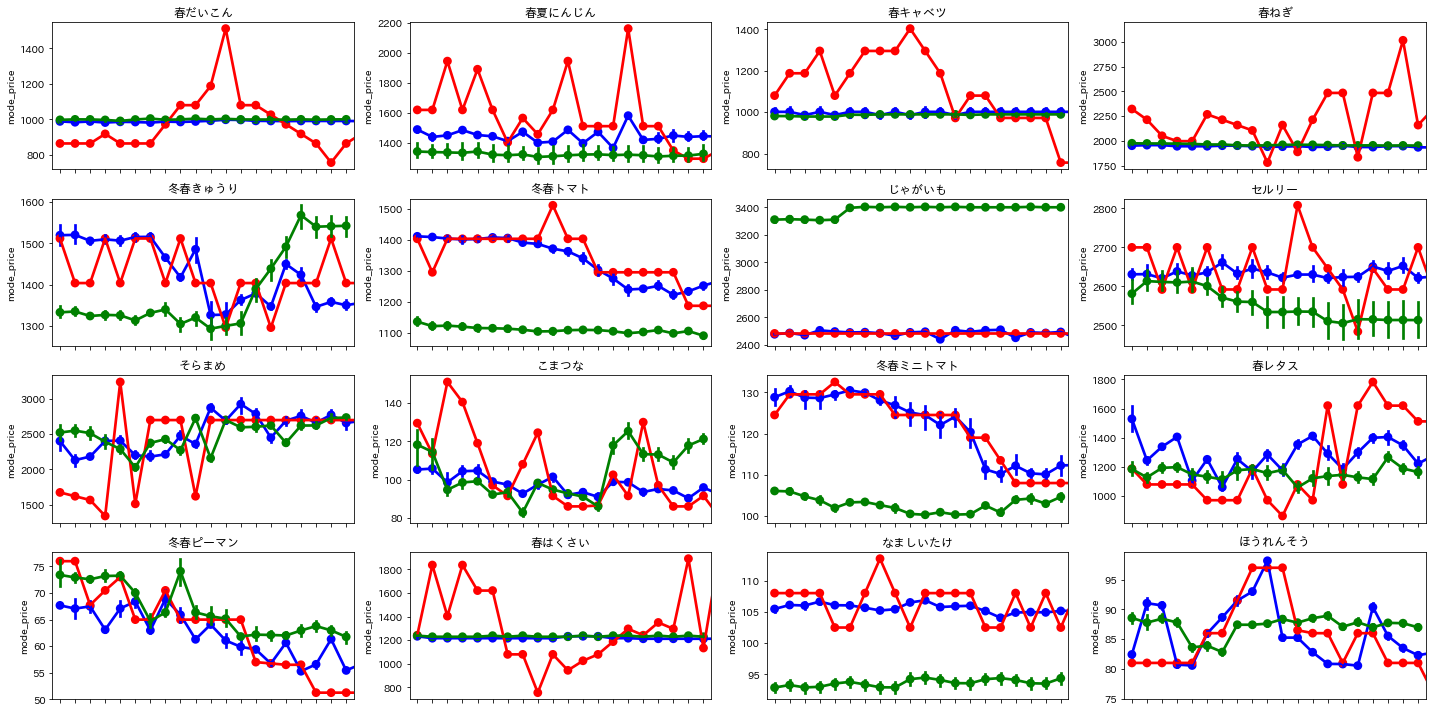

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(20, 10))
ax_list = ax.flatten()

for idx, kind_detail in enumerate(df_val["kind_detail"].unique()):
    sns.pointplot(x="date", y="mode_price_pred", data=df_val.query("kind_detail == @kind_detail"), color="blue", ax=ax_list[idx])
    sns.pointplot(x="date", y="mode_price", data=df_val.query("kind_detail == @kind_detail"), color="red", ax=ax_list[idx])
    sns.pointplot(x="date", y="mode_price", data=df_price_predict.query("kind_detail == @kind_detail"), color="green",  ax=ax_list[idx])
    ax_list[idx].set_title(kind_detail)
    ax_list[idx].set_xlabel(None)
    ax_list[idx].set_xticklabels([])

plt.tight_layout()
plt.show()

## visualize feature importance

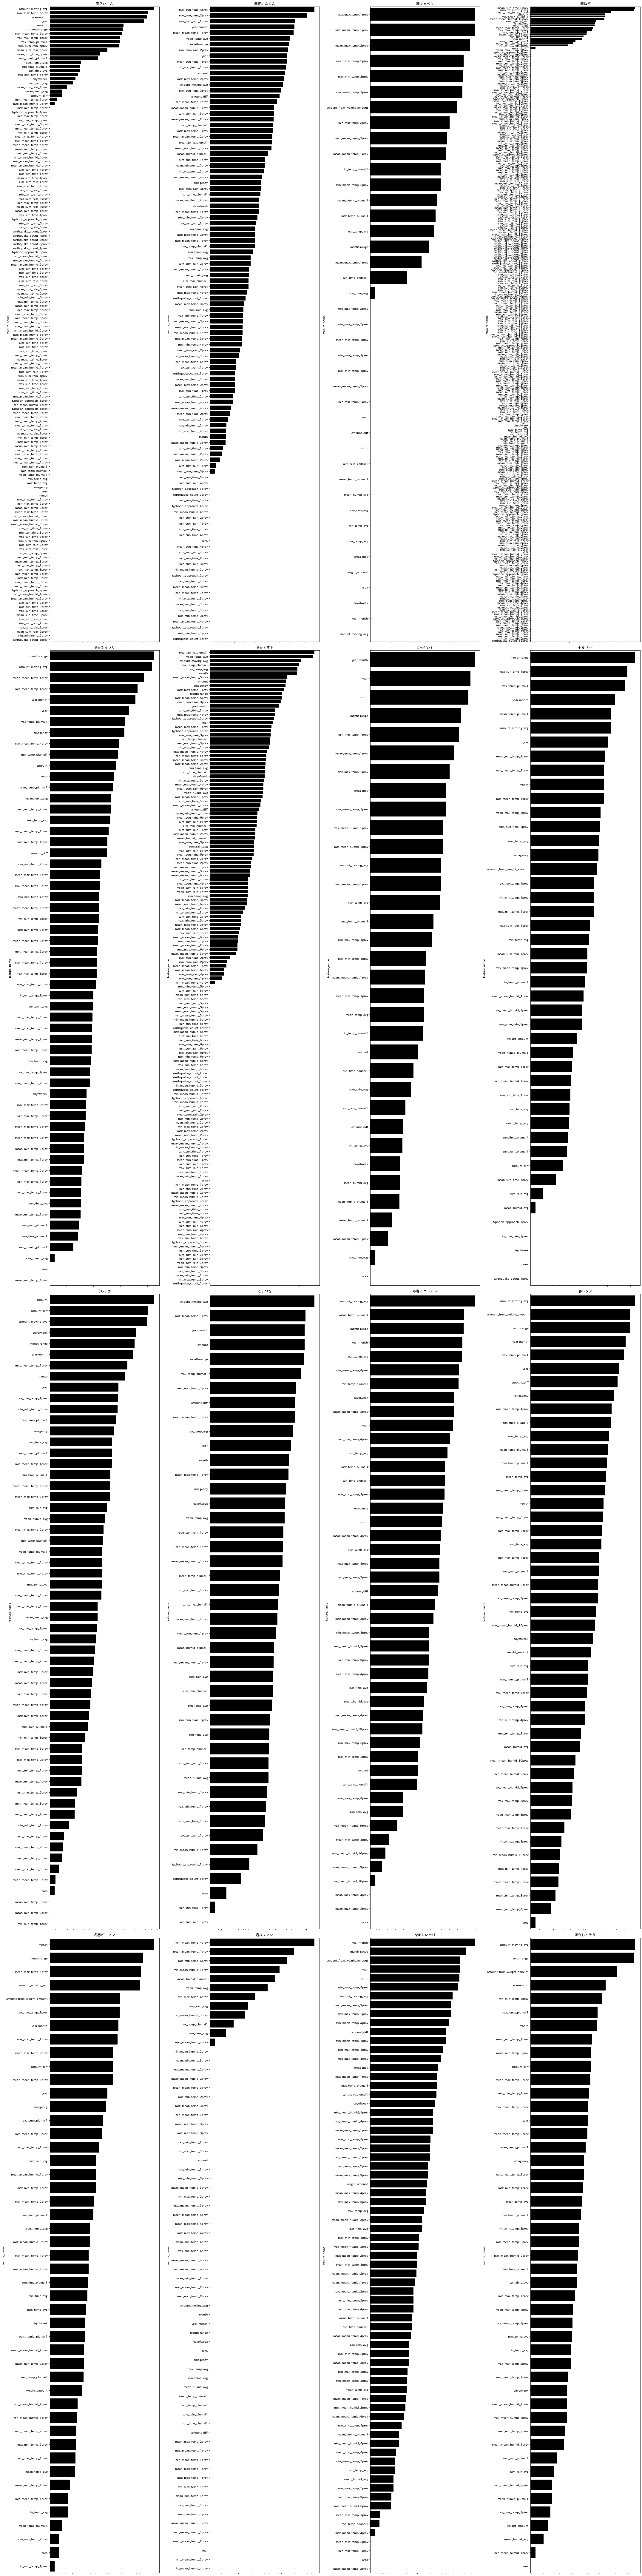

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(30, 120))
ax_list = ax.flatten()

for idx, kind_detail in enumerate(df_price_predict["kind_detail"].unique()):
    sns.barplot(
        x="feature_importance",
        y="feature_name",
        data=model_price_dict[kind_detail].df_feature_importance.sort_values(by="feature_importance", ascending=False),
        ax=ax_list[idx],
        color="black"
    )
    ax_list[idx].set_xscale("log")
    ax_list[idx].set_title(kind_detail)
    ax_list[idx].set_xlabel(None)
    ax_list[idx].set_xticklabels([])
    
plt.tight_layout()
plt.show()